# Mean Reversion Trading Strategy for Stock Q

## Model
Stock Q follows a **random walk with drift**: $P_t = \alpha + \beta t + r_t$

The residuals $r_t$ are **mean-reverting** (Ornstein-Uhlenbeck process), allowing us to profit when price deviates from trend.

## Strategy
- **LONG** when $z_t < -1.5\sigma$ (price below trend)
- **SHORT** when $z_t > +1.5\sigma$ (price above trend)  
- **EXIT** when $z_t$ crosses 0 (reversion to mean)

In [242]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from scipy import stats
from statsmodels.tsa.stattools import adfuller
from statsmodels.regression.linear_model import OLS
from statsmodels.tools import add_constant
import warnings
warnings.filterwarnings('ignore')

plt.rcParams['figure.figsize'] = (14, 5)
plt.rcParams['axes.grid'] = True
plt.rcParams['grid.alpha'] = 0.3

# Parameters
TRANSACTION_COST_BPS = 10
ENTRY_THRESHOLD = 1.5
EXIT_THRESHOLD = 0.0
MIN_HISTORY = 1000

## 1. Load Data and Fit Linear Trend

In [243]:
# Load data
df = pd.read_csv('simulated_prices.csv')
stock_Q = df['Q'].values
T = len(stock_Q)
t = np.arange(T)

# Fit linear trend: P_t = alpha + beta * t + residual
X = add_constant(t)
model = OLS(stock_Q, X).fit()
alpha, beta = model.params[0], model.params[1]
trend = model.predict(X)
residuals = stock_Q - trend

print(f"Data: {T} days, ${stock_Q[0]:.2f} -> ${stock_Q[-1]:.2f} ({(stock_Q[-1]/stock_Q[0]-1)*100:.1f}% return)")
print(f"Trend: P_t = {alpha:.2f} + {beta:.4f}t  (R² = {model.rsquared:.3f})")
print(f"Residual std: ${residuals.std():.2f}")

Data: 2521 days, $107.00 -> $185.45 (73.3% return)
Trend: P_t = 106.99 + 0.0239t  (R² = 0.667)
Residual std: $12.30


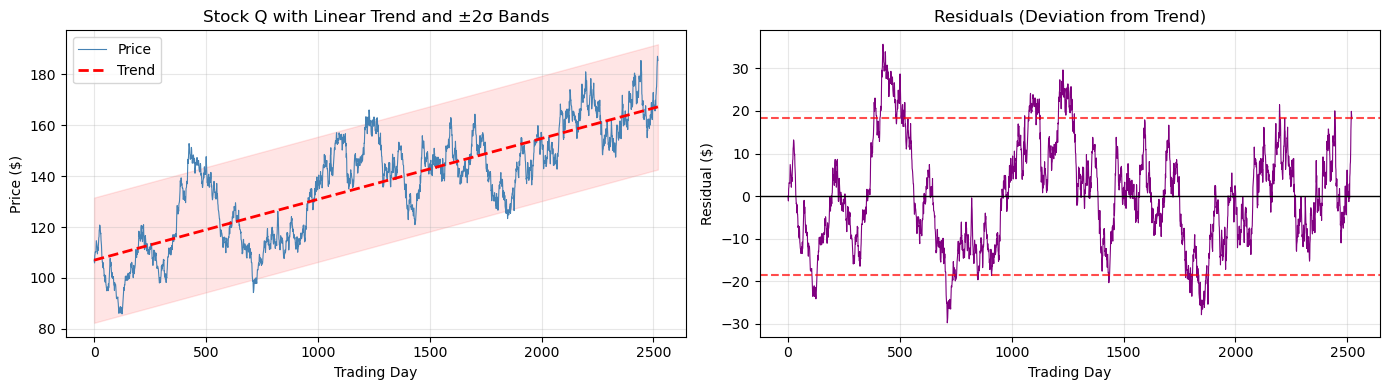

In [244]:
# Plot price with trend
fig, axes = plt.subplots(1, 2, figsize=(14, 4))

axes[0].plot(stock_Q, color='steelblue', linewidth=0.8, label='Price')
axes[0].plot(trend, color='red', linewidth=2, linestyle='--', label='Trend')
axes[0].fill_between(t, trend - 2*residuals.std(), trend + 2*residuals.std(), color='red', alpha=0.1)
axes[0].set_xlabel('Trading Day')
axes[0].set_ylabel('Price ($)')
axes[0].set_title('Stock Q with Linear Trend and ±2σ Bands')
axes[0].legend()

axes[1].plot(residuals, color='purple', linewidth=0.8)
axes[1].axhline(0, color='black', linewidth=1)
axes[1].axhline(1.5*residuals.std(), color='red', linestyle='--', alpha=0.7)
axes[1].axhline(-1.5*residuals.std(), color='red', linestyle='--', alpha=0.7)
axes[1].set_xlabel('Trading Day')
axes[1].set_ylabel('Residual ($)')
axes[1].set_title('Residuals (Deviation from Trend)')

plt.tight_layout()
plt.show()

## 2. Statistical Tests for Mean Reversion

In [245]:
# ADF Test
adf_stat, adf_pval = adfuller(residuals, autolag='AIC')[:2]

# Hurst Exponent
lags = range(2, 100)
tau = [np.std(np.subtract(residuals[lag:], residuals[:-lag])) for lag in lags]
H_residuals = stats.linregress(np.log(list(lags)), np.log(tau))[0]

# OU Parameters (AR(1) regression)
ar_model = OLS(residuals[1:], add_constant(residuals[:-1])).fit()
ar_coef = ar_model.params[1]
theta = 1 - ar_coef
half_life = np.log(2) / theta if theta > 0 else np.inf

print("Mean Reversion Evidence:")
print(f"  ADF p-value:    {adf_pval:.4f} {'✓ STATIONARY' if adf_pval < 0.05 else '✗'}")
print(f"  Hurst Exponent: {H_residuals:.3f} {'✓ MEAN-REVERTING' if H_residuals < 0.5 else '✗'} (H<0.5)")
print(f"  AR(1) coef:     {ar_coef:.4f} {'✓' if ar_coef < 1 else '✗'} (<1 confirms mean reversion)")
print(f"  Half-life:      {half_life:.0f} days (deviations halve in ~{half_life:.0f} days)")

Mean Reversion Evidence:
  ADF p-value:    0.0024 ✓ STATIONARY
  Hurst Exponent: 0.436 ✓ MEAN-REVERTING (H<0.5)
  AR(1) coef:     0.9886 ✓ (<1 confirms mean reversion)
  Half-life:      61 days (deviations halve in ~61 days)


## 3. Backtest Functions

In [246]:
def backtest_strategy(prices, z_scores, entry_thresh, exit_thresh, 
                      initial_capital=100000, position_pct=0.8, transaction_cost_bps=10):
    """Full sample backtest with known z-scores."""
    n = len(prices)
    position, shares, cash = 0, 0, initial_capital
    entry_price, entry_day, entry_z = 0, 0, 0
    equity, trades = [], []
    tc_rate = transaction_cost_bps / 10000
    
    for day in range(n):
        price, z = prices[day], z_scores[day]
        
        if position == 0:  # Look for entry
            if z > entry_thresh or z < -entry_thresh:
                shares_to_trade = int(initial_capital * position_pct / price)
                if z > entry_thresh:  # Short
                    position, shares = -1, -shares_to_trade
                    cash += shares_to_trade * price * (1 - tc_rate)
                else:  # Long
                    position, shares = 1, shares_to_trade
                    cash -= shares_to_trade * price * (1 + tc_rate)
                entry_price, entry_day, entry_z = price, day, z
                
        elif (position == 1 and z >= exit_thresh) or (position == -1 and z <= -exit_thresh):
            # Close position
            if position == 1:
                pnl = shares * (price - entry_price) - 2 * shares * entry_price * tc_rate
                cash += shares * price * (1 - tc_rate)
            else:
                pnl = -shares * (entry_price - price) - 2 * (-shares) * entry_price * tc_rate
                cash -= -shares * price * (1 + tc_rate)
            trades.append({'entry_day': entry_day, 'exit_day': day, 'type': 'LONG' if position==1 else 'SHORT',
                          'pnl': pnl, 'holding_days': day - entry_day})
            position, shares = 0, 0
        
        equity.append(cash + shares * price)
    
    # Force close at end
    if position != 0:
        price = prices[-1]
        if position == 1:
            pnl = shares * (price - entry_price) - 2 * shares * entry_price * tc_rate
            cash += shares * price * (1 - tc_rate)
        else:
            pnl = -shares * (entry_price - price) - 2 * (-shares) * entry_price * tc_rate
            cash -= -shares * price * (1 + tc_rate)
        trades.append({'entry_day': entry_day, 'exit_day': n-1, 'type': 'LONG' if position==1 else 'SHORT',
                      'pnl': pnl, 'holding_days': n-1-entry_day, 'forced_close': True})
        equity[-1] = cash
    
    return np.array(equity), trades

def expanding_backtest(prices, min_history=1000, entry_thresh=1.5, exit_thresh=0.0,
                       initial_capital=100000, position_pct=0.8, transaction_cost_bps=10):
    """Out-of-sample backtest using expanding window (no look-ahead bias)."""
    n = len(prices)
    position, shares, cash = 0, 0, initial_capital
    entry_price, entry_day, entry_z = 0, 0, 0
    equity = [initial_capital] * min_history
    trades, z_scores = [], [0.0] * min_history
    tc_rate = transaction_cost_bps / 10000
    
    for day in range(min_history, n):
        # Fit trend on ALL historical data
        hist_prices = prices[:day]
        hist_t = np.arange(day)
        model = OLS(hist_prices, add_constant(hist_t)).fit()
        alpha, beta = model.params[0], model.params[1]
        
        # Extrapolate to today and compute z-score
        expected_price = alpha + beta * day
        hist_residuals = hist_prices - (alpha + beta * hist_t)
        z = (prices[day] - expected_price) / hist_residuals.std()
        z_scores.append(z)
        
        price = prices[day]
        
        if position == 0:
            if z > entry_thresh or z < -entry_thresh:
                shares_to_trade = int(initial_capital * position_pct / price)
                if z > entry_thresh:
                    position, shares = -1, -shares_to_trade
                    cash += shares_to_trade * price * (1 - tc_rate)
                else:
                    position, shares = 1, shares_to_trade
                    cash -= shares_to_trade * price * (1 + tc_rate)
                entry_price, entry_day, entry_z = price, day, z
                
        elif (position == 1 and z >= exit_thresh) or (position == -1 and z <= -exit_thresh):
            if position == 1:
                pnl = shares * (price - entry_price) - 2 * shares * entry_price * tc_rate
                cash += shares * price * (1 - tc_rate)
            else:
                pnl = -shares * (entry_price - price) - 2 * (-shares) * entry_price * tc_rate
                cash -= -shares * price * (1 + tc_rate)
            trades.append({'entry_day': entry_day, 'exit_day': day, 'type': 'LONG' if position==1 else 'SHORT',
                          'pnl': pnl, 'holding_days': day - entry_day})
            position, shares = 0, 0
        
        equity.append(cash + shares * price)
    
    # Force close
    if position != 0:
        price = prices[-1]
        if position == 1:
            pnl = shares * (price - entry_price) - 2 * shares * entry_price * tc_rate
            cash += shares * price * (1 - tc_rate)
        else:
            pnl = -shares * (entry_price - price) - 2 * (-shares) * entry_price * tc_rate
            cash -= -shares * price * (1 + tc_rate)
        trades.append({'entry_day': entry_day, 'exit_day': n-1, 'type': 'LONG' if position==1 else 'SHORT',
                      'pnl': pnl, 'holding_days': n-1-entry_day, 'forced_close': True})
        equity[-1] = cash
    
    return np.array(equity), trades, np.array(z_scores)

def calc_metrics(equity, trades, initial_capital=100000):
    """Calculate performance metrics."""
    ret = (equity[-1] - initial_capital) / initial_capital
    daily_ret = np.diff(equity) / equity[:-1]
    sharpe = np.sqrt(252) * daily_ret.mean() / daily_ret.std() if daily_ret.std() > 0 else 0
    max_dd = ((equity - np.maximum.accumulate(equity)) / np.maximum.accumulate(equity)).min()
    trades_df = pd.DataFrame(trades) if trades else pd.DataFrame()
    win_rate = (trades_df['pnl'] > 0).mean() if len(trades_df) > 0 else 0
    return {'return': ret, 'sharpe': sharpe, 'max_dd': max_dd, 'n_trades': len(trades), 'win_rate': win_rate}

## 4. Full Sample Backtest (Reference)

In [247]:
# Z-score for full sample
z_score = (residuals - residuals.mean()) / residuals.std()

# Run backtest
equity, trades = backtest_strategy(stock_Q, z_score, ENTRY_THRESHOLD, EXIT_THRESHOLD, 
                                   transaction_cost_bps=TRANSACTION_COST_BPS)
metrics = calc_metrics(equity, trades)

# Buy and hold benchmark
bh_shares = int(100000 / stock_Q[0])
bh_equity = bh_shares * stock_Q + (100000 - bh_shares * stock_Q[0])
bh_metrics = calc_metrics(bh_equity, [])

print("Full Sample Results (has look-ahead bias):")
print(f"  Strategy: {metrics['return']*100:.1f}% return, {metrics['sharpe']:.2f} Sharpe, {metrics['max_dd']*100:.1f}% max DD, {metrics['n_trades']} trades, {metrics['win_rate']*100:.0f}% win rate")
print(f"  Buy&Hold: {bh_metrics['return']*100:.1f}% return, {bh_metrics['sharpe']:.2f} Sharpe, {bh_metrics['max_dd']*100:.1f}% max DD")

Full Sample Results (has look-ahead bias):
  Strategy: 104.7% return, 0.94 Sharpe, -10.9% max DD, 9 trades, 100% win rate
  Buy&Hold: 73.3% return, 0.36 Sharpe, -38.3% max DD


## 5. Expanding Window Backtest (Out-of-Sample)

In [248]:
# Run expanding window backtest
exp_equity, exp_trades, exp_z = expanding_backtest(stock_Q, min_history=MIN_HISTORY,
                                                    entry_thresh=ENTRY_THRESHOLD, exit_thresh=EXIT_THRESHOLD,
                                                    transaction_cost_bps=TRANSACTION_COST_BPS)
exp_metrics = calc_metrics(exp_equity, exp_trades)

# Buy and hold for same period
bh_exp_start = stock_Q[MIN_HISTORY]
bh_exp_shares = int(100000 / bh_exp_start)
bh_exp_equity = np.concatenate([[100000]*MIN_HISTORY, 
                                bh_exp_shares * stock_Q[MIN_HISTORY:] + (100000 - bh_exp_shares * bh_exp_start)])
bh_exp_ret = (bh_exp_equity[-1] - 100000) / 100000
bh_exp_dd = ((bh_exp_equity - np.maximum.accumulate(bh_exp_equity)) / np.maximum.accumulate(bh_exp_equity)).min()
bh_exp_daily = np.diff(bh_exp_equity[MIN_HISTORY:]) / bh_exp_equity[MIN_HISTORY:-1]
bh_exp_sharpe = np.sqrt(252) * bh_exp_daily.mean() / bh_exp_daily.std()

print(f"Expanding Window Results (Day {MIN_HISTORY} to {len(stock_Q)-1}, no look-ahead bias):")
print(f"  Strategy: {exp_metrics['return']*100:.1f}% return, {exp_metrics['sharpe']:.2f} Sharpe, {exp_metrics['max_dd']*100:.1f}% max DD, {exp_metrics['n_trades']} trades, {exp_metrics['win_rate']*100:.0f}% win rate")
print(f"  Buy&Hold: {bh_exp_ret*100:.1f}% return, {bh_exp_sharpe:.2f} Sharpe, {bh_exp_dd*100:.1f}% max DD")

print(f"\nTrades:")
for i, tr in enumerate(exp_trades):
    fc = ' (forced)' if tr.get('forced_close') else ''
    print(f"  {i+1}. {tr['type']} Day {tr['entry_day']}->{tr['exit_day']}: ${tr['pnl']:,.0f} ({tr['holding_days']}d){fc}")

Expanding Window Results (Day 1000 to 2520, no look-ahead bias):
  Strategy: 54.7% return, 0.70 Sharpe, -10.6% max DD, 7 trades, 100% win rate
  Buy&Hold: 36.2% return, 0.34 Sharpe, -27.1% max DD

Trades:
  1. SHORT Day 1029->1138: $7,135 (109d)
  2. SHORT Day 1214->1287: $7,385 (73d)
  3. LONG Day 1398->1463: $11,752 (65d)
  4. LONG Day 1774->1908: $10,723 (134d)
  5. SHORT Day 2196->2265: $8,362 (69d)
  6. SHORT Day 2444->2454: $8,822 (10d)
  7. SHORT Day 2518->2520: $541 (2d) (forced)


## 6. Results Visualization

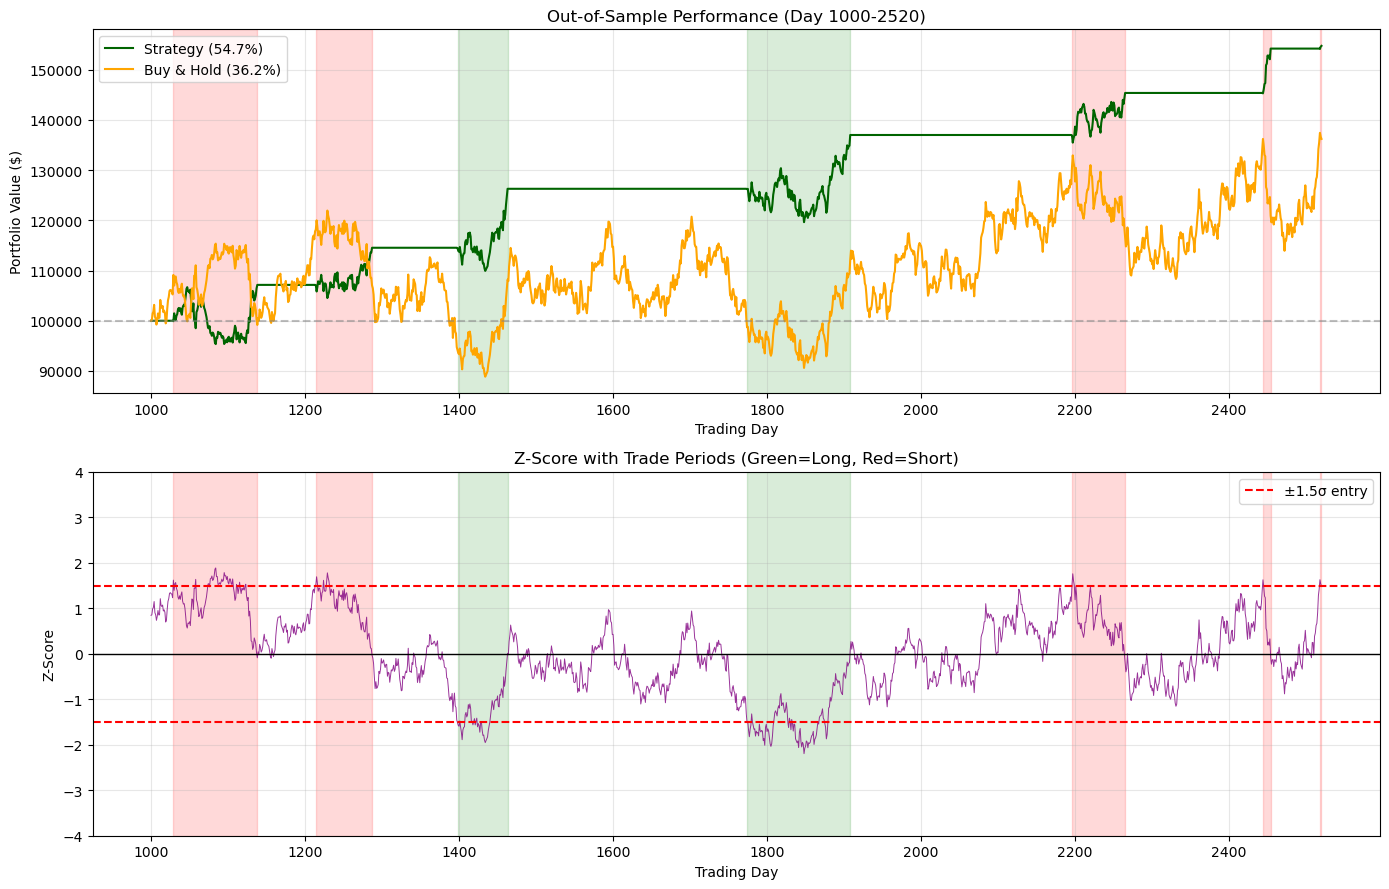

In [249]:
fig, axes = plt.subplots(2, 1, figsize=(14, 9))

# Equity curves (from MIN_HISTORY onwards)
days = np.arange(MIN_HISTORY, len(stock_Q))
ax1 = axes[0]
ax1.plot(days, exp_equity[MIN_HISTORY:], color='darkgreen', linewidth=1.5, label=f'Strategy ({exp_metrics["return"]*100:.1f}%)')
ax1.plot(days, bh_exp_equity[MIN_HISTORY:], color='orange', linewidth=1.5, label=f'Buy & Hold ({bh_exp_ret*100:.1f}%)')
ax1.axhline(100000, color='gray', linestyle='--', alpha=0.5)
for tr in exp_trades:
    color = 'green' if tr['type'] == 'LONG' else 'red'
    ax1.axvspan(tr['entry_day'], tr['exit_day'], alpha=0.15, color=color)
ax1.set_xlabel('Trading Day')
ax1.set_ylabel('Portfolio Value ($)')
ax1.set_title(f'Out-of-Sample Performance (Day {MIN_HISTORY}-{len(stock_Q)-1})')
ax1.legend(loc='upper left')

# Z-score with trades
ax2 = axes[1]
ax2.plot(days, exp_z[MIN_HISTORY:], color='purple', linewidth=0.7, alpha=0.8)
ax2.axhline(0, color='black', linewidth=1)
ax2.axhline(ENTRY_THRESHOLD, color='red', linestyle='--', label=f'±{ENTRY_THRESHOLD}σ entry')
ax2.axhline(-ENTRY_THRESHOLD, color='red', linestyle='--')
for tr in exp_trades:
    color = 'green' if tr['type'] == 'LONG' else 'red'
    ax2.axvspan(tr['entry_day'], tr['exit_day'], alpha=0.15, color=color)
ax2.set_xlabel('Trading Day')
ax2.set_ylabel('Z-Score')
ax2.set_title('Z-Score with Trade Periods (Green=Long, Red=Short)')
ax2.set_ylim(-4, 4)
ax2.legend(loc='upper right')

plt.tight_layout()
plt.show()

## 7. Summary

In [250]:
print("="*70)
print("MEAN REVERSION STRATEGY - SUMMARY")
print("="*70)

print(f"\nModel: P_t = {alpha:.2f} + {beta:.4f}t + r_t")
print(f"Mean reversion confirmed: ADF p={adf_pval:.4f}, Hurst={H_residuals:.3f}, Half-life={half_life:.0f} days")

print(f"\nTrading Rules:")
print(f"  Entry: |z| > {ENTRY_THRESHOLD}σ  |  Exit: z crosses 0  |  Cost: {TRANSACTION_COST_BPS}bps")

print(f"\nPerformance Comparison:")
print(f"  {'Metric':<20} {'Full Sample':>15} {'Expanding (OOS)':>18} {'Buy & Hold':>15}")
print(f"  {'-'*20} {'-'*15} {'-'*18} {'-'*15}")
print(f"  {'Return':<20} {metrics['return']*100:>14.1f}% {exp_metrics['return']*100:>17.1f}% {bh_exp_ret*100:>14.1f}%")
print(f"  {'Sharpe Ratio':<20} {metrics['sharpe']:>15.2f} {exp_metrics['sharpe']:>18.2f} {bh_exp_sharpe:>15.2f}")
print(f"  {'Max Drawdown':<20} {metrics['max_dd']*100:>14.1f}% {exp_metrics['max_dd']*100:>17.1f}% {bh_exp_dd*100:>14.1f}%")
print(f"  {'Win Rate':<20} {metrics['win_rate']*100:>14.0f}% {exp_metrics['win_rate']*100:>17.0f}% {'N/A':>15}")

print(f"\nKey Findings:")
if exp_metrics['return'] > bh_exp_ret:
    print(f"  ✓ Strategy outperforms buy & hold by {(exp_metrics['return']-bh_exp_ret)*100:.1f}%")
if exp_metrics['sharpe'] > bh_exp_sharpe:
    print(f"  ✓ Higher risk-adjusted returns (Sharpe {exp_metrics['sharpe']:.2f} vs {bh_exp_sharpe:.2f})")
if abs(exp_metrics['max_dd']) < abs(bh_exp_dd):
    print(f"  ✓ Lower drawdown ({exp_metrics['max_dd']*100:.1f}% vs {bh_exp_dd*100:.1f}%)")

print(f"\nCaveats: Full sample has look-ahead bias. No slippage/market impact modeled.")

MEAN REVERSION STRATEGY - SUMMARY

Model: P_t = 106.99 + 0.0239t + r_t
Mean reversion confirmed: ADF p=0.0024, Hurst=0.436, Half-life=61 days

Trading Rules:
  Entry: |z| > 1.5σ  |  Exit: z crosses 0  |  Cost: 10bps

Performance Comparison:
  Metric                   Full Sample    Expanding (OOS)      Buy & Hold
  -------------------- --------------- ------------------ ---------------
  Return                        104.7%              54.7%           36.2%
  Sharpe Ratio                    0.94               0.70            0.34
  Max Drawdown                  -10.9%             -10.6%          -27.1%
  Win Rate                        100%               100%             N/A

Key Findings:
  ✓ Strategy outperforms buy & hold by 18.5%
  ✓ Higher risk-adjusted returns (Sharpe 0.70 vs 0.34)
  ✓ Lower drawdown (-10.6% vs -27.1%)

Caveats: Full sample has look-ahead bias. No slippage/market impact modeled.
